In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

gender_sub = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
train = pd.read_csv('/kaggle/input/titanic/train.csv')
train


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### **Column Descriptions**

**Survived:** Binary. 0 for not survived, 1 for survived.  
**Pclass:** Passenger class on the ship. 1 for first, 2 for second, 3 for third.  
**Name:** Name of the passenger.  
**Sex:** Sex of the passenger.  
**Age:** Age in years of the passenger.  
**SibSp:** Siblings or spouses per passenger.  
**Parch:** Parents or children per passenger.  
**Ticket:** Code of passenger ticket.  
**Fare:** Amount spend on the trip.  
**Cabin:** Cabin number in the ship.  
**Embarked:** Local of boarding. S for Southampton, C for Cherbourg, and Q for Queenstown  

In [2]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## **Previous Analysis**

Let´s take a look at the general analysis of the data. We're gonna generate visualizations based on the main features. Since our information target is the surviving condition, seems pertinent to analyse the statistics involving the other features related with survivance numbers.

In [3]:
#Preparing a dataset copy for analysis
import matplotlib.pyplot as plt
import seaborn as sns

df_analysis = train.copy()
df_analysis['Condition'] = df_analysis['Survived'].apply(lambda x: 'Survived' if x == 1 else 'Died')
df_analysis['Age'].fillna(int(df_analysis['Age'].mean()), inplace=True)

In [4]:
def plot_group_chart(data, x, y, title, metric, hue, palette):
    sns.set_theme(style="whitegrid")
    g = sns.catplot(
        data=data, kind="bar",
        x=x, y=y, hue=hue,
        ci="sd", palette=palette, alpha=.6, height=6)
    g.despine(left=True)
    g.set(title=title)
    g.set_axis_labels("", metric + " Passengers")


In [5]:
def plotly_group_bar(data):
    plot = px.Figure(data=[
    px.Bar(name = data['name1'], x = data['xdata'], y = data['data1'], marker=dict(color=data['color1'])),
    px.Bar(name = data['name2'], x = data['xdata'], y = data['data2'], marker=dict(color=data['color2']))])

    plot.layout.update({
                       'margin': {'t': 40, 'b': 20, 'l': 20, 'r': 20},
                       'width': 600,
                       'height': 400})
    # plot.update_layout(paper_bgcolor='rgba(0,0,0,0)',
    #                    title={'font': {'color': 'white'}},
    #                    xaxis_title={'font': {'color': 'white'}},
    #                    yaxis_title={'font': {'color': 'white'}})
    return plot

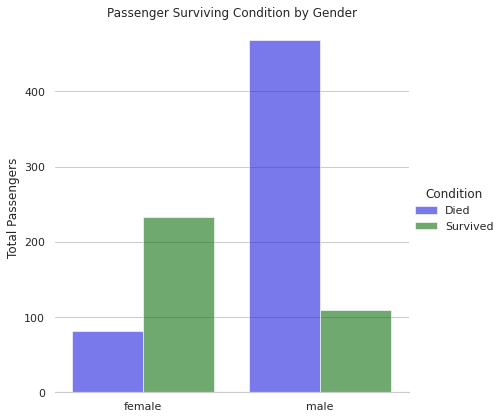

In [6]:
#Survivors Statistics by Gender
sum_data = df_analysis.groupby(["Sex", "Condition"])["PassengerId"].count().reset_index()
plot_group_chart(sum_data, "Sex", "PassengerId",'Passenger Surviving Condition by Gender', "Total", 'Condition', ["blue", "green"])


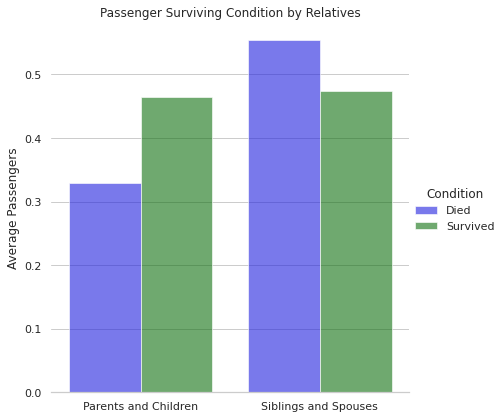

In [7]:
#Surviving Statistics Based on The Relatives
sum_data_parch = df_analysis.groupby(["Condition"])["Parch"].mean().reset_index()
sum_data_parch.rename(columns={'Parch': 'Mean'}, inplace=True)
sum_data_parch['Type'] = "Parents and Children"
sum_data_sbsp = df_analysis.groupby(["Condition"])["SibSp"].mean().reset_index()
sum_data_sbsp.rename(columns={'SibSp': 'Mean'}, inplace=True)
sum_data_sbsp['Type'] = "Siblings and Spouses"
sum_data = pd.concat([sum_data_parch, sum_data_sbsp])

plot_group_chart(sum_data, "Type", "Mean",'Passenger Surviving Condition by Relatives', "Average", 'Condition', ["blue", "green"])


In [8]:
from functools import reduce
import itertools

def data_age_interval(df):
    labels_age = ['0-15', '16-30', '31-45', '46-60', '61-75', '76-100']
    bins = [0, 15, 30, 45, 60, 75, 100]
    df_analysed = df.copy()
    df_analysed["Age_Interval"] = pd.cut(df_analysed["Age"], bins=bins, right=False, labels=labels_age)
    return df_analysed

def data_group_age(df, column, label_groups):
    def concatenate(x, y):
        if isinstance(x, pd.DataFrame):
            analysis_group_one = x
        else:
            analysis_group_one = df[df[column] == x].groupby(["Age_Interval"])[column].count().reset_index()
        analysis_group_two = df[df[column] == y].groupby(["Age_Interval"])[column].count().reset_index()
        return pd.concat([analysis_group_one, analysis_group_two], axis=0)
        
    analysis_group = reduce(concatenate, label_groups).rename(columns={column: 'Count'})
    analysis_group[column] = list(itertools.chain.from_iterable([[i] * 6 for i in label_groups]))
    
    return analysis_group

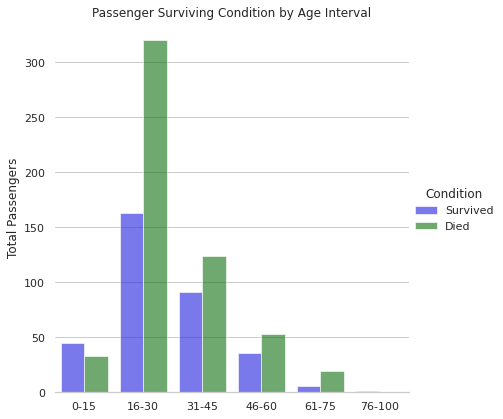

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

df_interval = data_age_interval(df_analysis)
age_analysis = data_group_age(df_interval, 'Condition', ['Survived', 'Died'])

plot_group_chart(age_analysis, "Age_Interval", "Count",'Passenger Surviving Condition by Age Interval', "Total", 'Condition', ["blue", "green"])

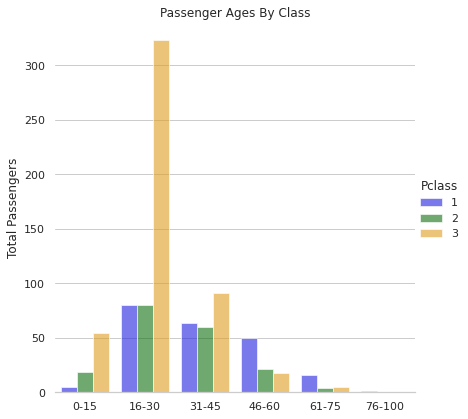

In [10]:
age_analysis = data_group_age(df_interval, 'Pclass', [1, 2, 3])
plot_group_chart(age_analysis, "Age_Interval", "Count",'Passenger Ages By Class', "Total", 'Pclass', ["blue", "green", 'orange'])

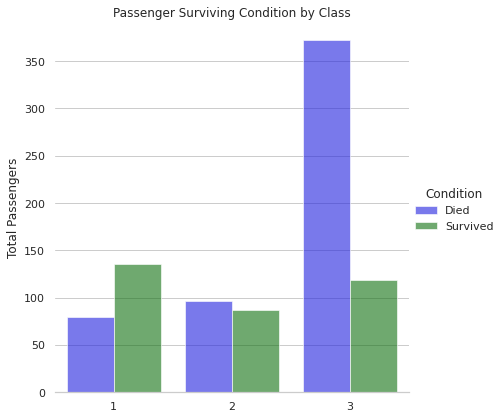

In [11]:
#Survivors Statistics by Class
sum_data = df_analysis.groupby(["Pclass", "Condition"])["PassengerId"].count().reset_index()
plot_group_chart(sum_data, "Pclass", "PassengerId",'Passenger Surviving Condition by Class', "Total", 'Condition', ["blue", "green"])


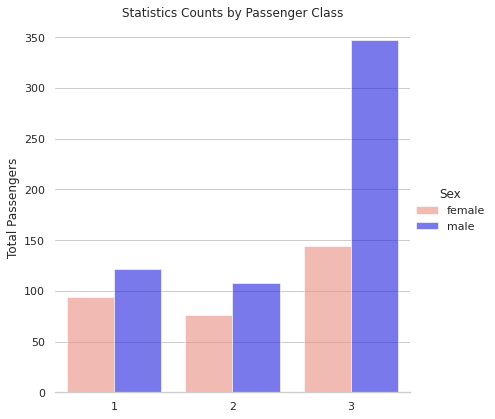

In [12]:
import plotly.graph_objects as px
import numpy

sum_data = df_analysis.groupby(['Pclass', 'Sex']).count().reset_index()
plot_group_chart(sum_data, "Pclass", "PassengerId",'Statistics Counts by Passenger Class', "Total", 'Sex', ["salmon", "blue"])


## **Cleaning and Encoding**

The columns 'Name', 'Ticket', 'Cabin' and 'Embarked' don't necessarily presents great contribution to the prediction, since they are not atributes to configure advantages or disvantages of survival. So, we delete this fields from the dataset.    

Afterwords, once the only field containing relevant missing values is "Age", let's fill this missing data with the average age of the total.

In [13]:
def cleaning_missing(df_pure):
    df = df_pure.copy()
    df.Age.fillna(int(df.Age.mean()), inplace=True)
    df.Fare.fillna(df.Fare.mean(), inplace=True)
    df.drop(columns=['Name','Ticket', 'Cabin', 'Embarked'], inplace=True)
    if 'Survived' in list(df.columns):
        return df.drop(columns=['Survived']), pd.DataFrame(df['Survived']).values.ravel()
    else:
        return df, None

Now, we can start the encode process with the features. For qualitative fields, the appropriate method is the Dummy conversion. Let's create new variables for each category data.    

For that, let's use two Scikit Learn library tools called OneHotEncoder, for encode fields in binaries, and ColumnTransformer, for column creations.

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def encoding_data(df_cleaned):
    pssg_id = list(df_cleaned['PassengerId'])
    df_cleaned.drop(columns=['PassengerId'], inplace=True)
    df_coded = pd.DataFrame(ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [0, 1])], remainder='passthrough')
                            .fit_transform(df_cleaned))
    df_coded.drop(columns=4, axis=1, inplace=True) # deleting the extra column for Sex. Now, 1 is Female, 0 is Male.
    df_coded['Id'] = pssg_id
    return df_coded

Now, let's scalling the features, so the average will be next to 0 and standard deviation next to 1. It will garant more fidelity to the model.

In [15]:
from sklearn.preprocessing import StandardScaler

def scalling_df(df_coded):
    df_coded_esc = pd.DataFrame(StandardScaler().fit_transform(df_coded))
    return df_coded_esc

So, it's time to define the training and test procedures for all types of models we'll use.

In [16]:
def metrics_validation(model, trainX, trainY):    
    type_metrics = ['accuracy', 'precision_macro', 'recall_macro']
    metrics = cross_validate(model, trainX, trainY, cv=20, scoring=type_metrics)
    dict_metrics = {met: metrics[met] for met in metrics}
    # fit_time, score_time, test_accuracy, test_precision_macro, test_recall_macro

    print(f' -- Accuracy -- Avg: {np.mean(dict_metrics["test_accuracy"])} Std: {np.std(dict_metrics["test_accuracy"])}')
    print(f' -- Fit -- Avg: {np.mean(dict_metrics["fit_time"])} Std: {np.std(dict_metrics["fit_time"])}')
    print(f' -- Score -- Avg: {np.mean(dict_metrics["score_time"])} Std: {np.std(dict_metrics["score_time"])}')
    print(f' -- Recall -- Avg: {np.mean(dict_metrics["test_recall_macro"])} Std: {np.std(dict_metrics["test_recall_macro"])}')

    return dict_metrics

In [17]:
def data_preparation(data):
    data_clean, dataY = cleaning_missing(data)
    data_encoded = encoding_data(data_clean)
    dataX = scalling_df(data_encoded.iloc[: , :-1]).to_numpy()
    
    return dataX, dataY

In [18]:
def training_validation(model, data):
    trainX, trainY = data_preparation(data)

    dict_metrics = metrics_validation(model, trainX, trainY)
    
    fig = plt.figure(figsize=(12,5))
    sns.set(rc={'axes.facecolor':'white'})
    ax = fig.add_subplot()
    ax.set_ylim(0.5, 1)
    sns.lineplot(data = pd.DataFrame(dict_metrics))

    
    return trainX, trainY, dict_metrics

In [19]:
def test_prediction(model, data):
    data['Survived'] = ''
    df_for_test, _ = cleaning_missing(data)
    df_t_encoded = encoding_data(df_for_test)
    testX = scalling_df(df_t_encoded.iloc[: , :]).to_numpy()

    prediction = pd.DataFrame({'PassengerId': df_t_encoded.Id})
    prediction['Survived'] = model.predict(testX)
    return prediction

## Analysing Variable Corelation on Dataset

In [20]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [21]:
data_clean, dataY = cleaning_missing(train)
dataX = encoding_data(data_clean)

train_dummified = pd.concat([dataX, pd.DataFrame(dataY)], axis=1)
train_dummified.columns = ['1st', '2nd', '3rd', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Id', 'Target']

**Pearson's Correlation Matrix:** 

Text(0.5, 1.0, 'Correlation Matrix')

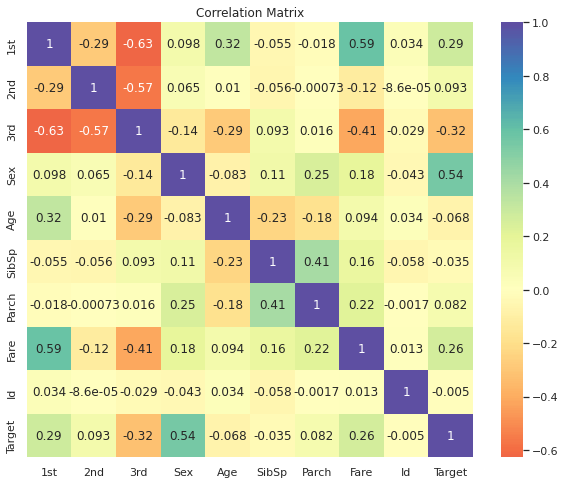

In [22]:
matrix = train_dummified.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='Spectral', center=0)
plt.title("Correlation Matrix")

**Mutual Info Score and Q² Coefficient by KBest Scores:**

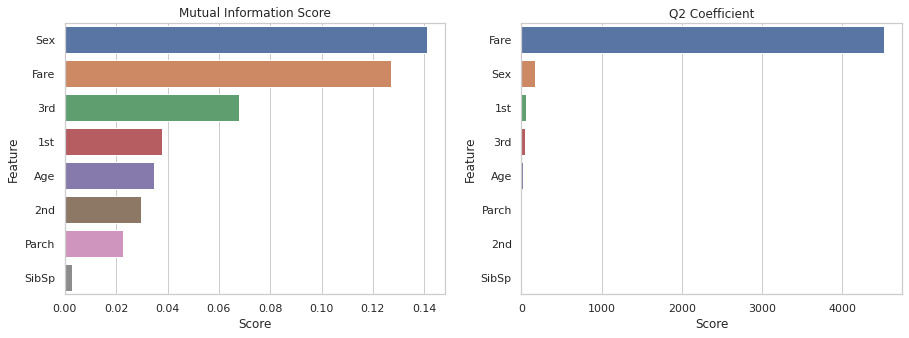

In [23]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

def plot_scores(ax, metric):
    def get_scores(metric):
        selector = SelectKBest(score_func=metric, k=1).fit(train_dummified.drop(columns={'Target'}), train_dummified['Target'])
        scores = pd.DataFrame(columns=['cols', 'scores'])
        scores['cols'], scores['scores'] = train_dummified.columns[:-2], selector.scores_[:-1]
        return scores
    
    sns.barplot(data=get_scores(metric).sort_values(by='scores', ascending=False), y='cols', x='scores', ax = ax)
    ax.set_title('Mutual Information Score') if metric is mutual_info_classif else ax.set_title('Q2 Coefficient')
    ax.set_xlabel('Score')
    ax.set_ylabel('Feature')

fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = False, figsize = (15, 5))
plot_scores(ax1, mutual_info_classif)
plot_scores(ax2, chi2)


## **Training the Model Naive Bayes**

Let's create the model Naive Bayes that will be trained and tested with the dataset. After, we will train this model with the cross validate method, using the Scikit Learn library.

 -- Accuracy -- Avg: 0.7522474747474748 Std: 0.056834559929028146
 -- Fit -- Avg: 0.008932578563690185 Std: 0.03376862683041975
 -- Score -- Avg: 0.0024295449256896973 Std: 0.00015329752645900063
 -- Recall -- Avg: 0.7172424525365702 Std: 0.06299796747850211


GaussianNB()

<Figure size 1080x1440 with 0 Axes>

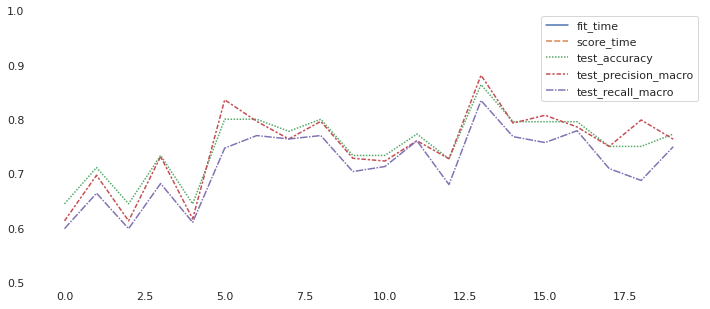

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate

train.drop(columns={'SibSp', 'Parch'}, inplace=True)
metrics_models = dict()

fig = plt.figure(figsize=(15,20))

modelNB = GaussianNB()
trainX, trainY, metrics_models['Bayes'] = training_validation(modelNB, train)
modelNB.fit(trainX, trainY)

In [25]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,111369,30.0000,C148,C


## **Training Model SVM**

 -- Accuracy -- Avg: 0.8080050505050504 Std: 0.06618633877673942
 -- Fit -- Avg: 0.02346463203430176 Std: 0.0003889621202419899
 -- Score -- Avg: 0.003471672534942627 Std: 0.00024098960165840245
 -- Recall -- Avg: 0.7861500155617802 Std: 0.0739557507028932


SVC(C=2.0, random_state=1)

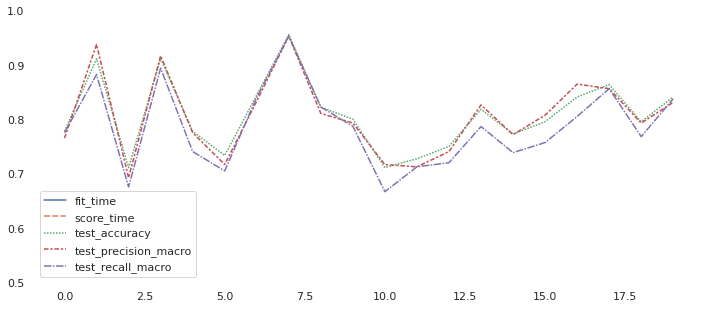

In [26]:
from sklearn.svm import SVC

modelSVM = SVC(C=2.0, gamma='scale', kernel='rbf', random_state=1)
trainX, trainY, metrics_models['SVM'] = training_validation(modelSVM, train)
modelSVM.fit(trainX, trainY)

link: https://medium.com/@msremigio/%C3%A1rvores-de-decis%C3%A3o-decision-trees-4cb6857671b3

## **Training DecisionTree Model**

 -- Accuracy -- Avg: 0.8158838383838385 Std: 0.05886048377606155
 -- Fit -- Avg: 0.0019153237342834472 Std: 0.00045164369340759946
 -- Score -- Avg: 0.002245378494262695 Std: 0.00016048826777119462
 -- Recall -- Avg: 0.7941526610644256 Std: 0.06606701407569707


DecisionTreeClassifier(max_depth=4, max_leaf_nodes=30, random_state=10)

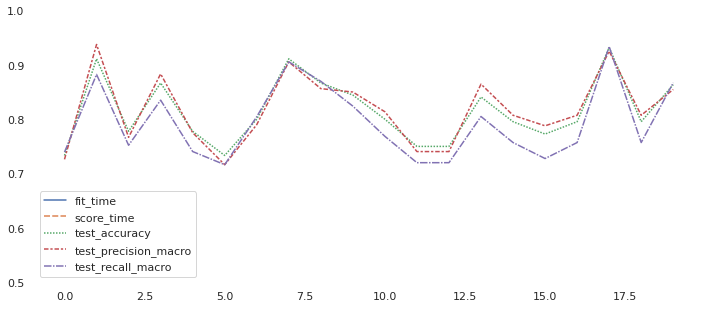

In [27]:
from sklearn.tree import DecisionTreeClassifier as DTC

modelDTC = DTC(max_depth=4, random_state=10, max_leaf_nodes=30)
trainX, trainY, metrics_models['DecisionTree'] = training_validation(modelDTC, train)
modelDTC.fit(trainX, trainY)

## **Training RandomForestModel**

 -- Accuracy -- Avg: 0.8238131313131312 Std: 0.042734935853154465
 -- Fit -- Avg: 0.2689704537391663 Std: 0.010195308433853694
 -- Score -- Avg: 0.015021514892578126 Std: 0.0009042423458896069
 -- Recall -- Avg: 0.8080143168378463 Std: 0.05327436406596037


RandomForestClassifier(criterion='entropy', random_state=0)

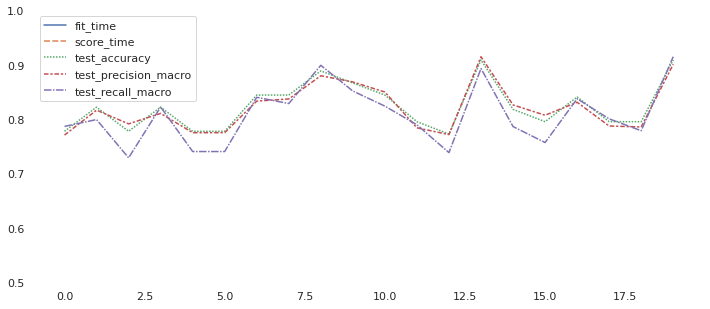

In [28]:
from sklearn.ensemble import RandomForestClassifier as RFC

modelRF = RFC(n_estimators=100, criterion='entropy', random_state=0)
trainX, trainY, metrics_models['RandomForest'] = training_validation(modelRF, train)
modelRF.fit(trainX, trainY)


## **Training Logistic Regression Model**

 -- Accuracy -- Avg: 0.7877777777777778 Std: 0.043769437939981365
 -- Fit -- Avg: 0.005431139469146728 Std: 0.001305556624230291
 -- Score -- Avg: 0.0023682236671447752 Std: 0.0001509724817959251
 -- Recall -- Avg: 0.7714499688764394 Std: 0.047672356091986154


LogisticRegression(max_iter=200, random_state=1)

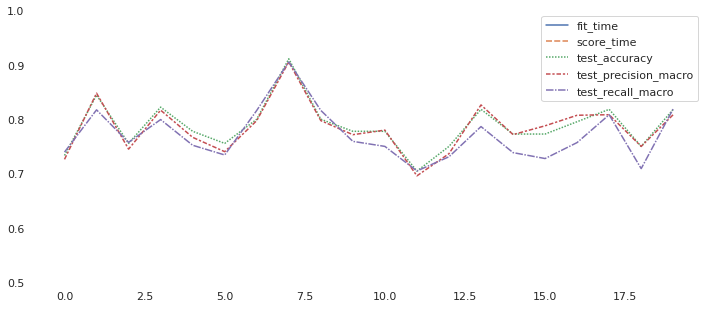

In [29]:
from sklearn.linear_model import LogisticRegression

modelLR = LogisticRegression(random_state=1, penalty="l2", max_iter=200)
trainX, trainY, metrics_models['LogisticRegression'] = training_validation(modelLR, train)
modelLR.fit(trainX, trainY)

## **Training XGBoost Model**
Decision Tree-based model

 -- Accuracy -- Avg: 0.8372474747474747 Std: 0.05583558328685726
 -- Fit -- Avg: 0.8303268194198609 Std: 0.03937375488760438
 -- Score -- Avg: 0.006808459758758545 Std: 0.00039085930487712384
 -- Recall -- Avg: 0.8169603952692188 Std: 0.06502038498756861


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0, reg_lambda=1, ...)

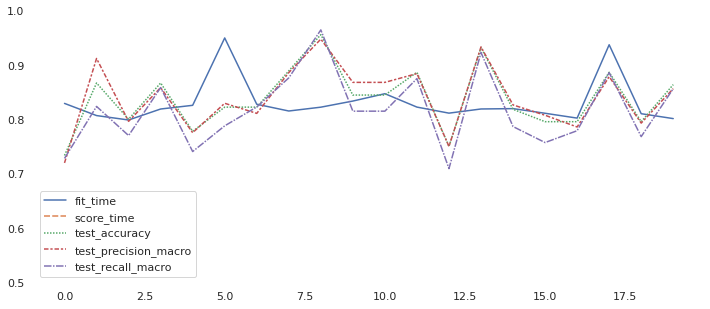

In [30]:
from xgboost import XGBClassifier as xgb

modelXGB = xgb(random_state=3, learning_rate=0.05, max_depth=4, n_estimators=200, objective="binary:logistic")
trainX, trainY, metrics_models['XGBoost'] = training_validation(modelXGB, train)

modelXGB.fit(trainX, trainY)

## **Training Light GBM Model**

Decision Tree-based model

 -- Accuracy -- Avg: 0.8216161616161616 Std: 0.06740364002563387
 -- Fit -- Avg: 0.06805444955825805 Std: 0.00922883421684598
 -- Score -- Avg: 0.003137946128845215 Std: 0.00012529195769240664
 -- Recall -- Avg: 0.8018868658574542 Std: 0.0760488694870881


LGBMClassifier(learning_rate=0.05, max_depth=7, num_leaves=150,
               objective='binary')

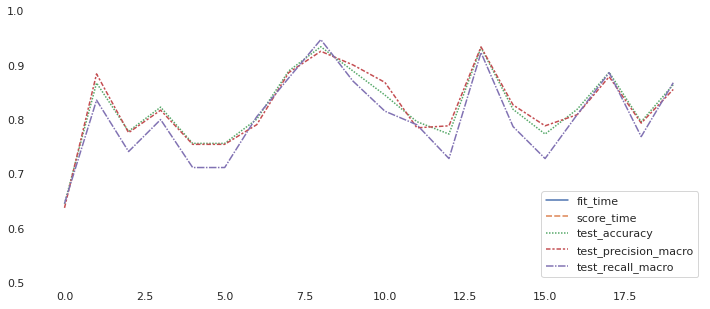

In [31]:
import lightgbm as LGBM

params = {'num_leaves': 150, 'objective': 'binary', 'max_depth': 7, 'learning_rate': .05, 'max_bin': 200}
modelLGBM = LGBM.LGBMClassifier(num_leaves=150, objective='binary', max_depth=7, learning_rate=.05)
trainX, trainY, metrics_models['LightGBM'] = training_validation(modelLGBM, train)

modelLGBM.fit(trainX, trainY)


## **Training CatBoost Model**

Decision Tree-based model, handles categorical data and non structured data.

In [32]:
import catboost as Cat
df_for_train, trainY = cleaning_missing(train)
df_for_train.drop(columns={'Sex'}, inplace=True)

modelCB = Cat.CatBoostClassifier(iterations=1, learning_rate=.05)
metrics_models['CatBoost'] = metrics_validation(modelCB, df_for_train, trainY)


0:	learn: 0.6828459	total: 57.2ms	remaining: 0us
0:	learn: 0.6829876	total: 1.48ms	remaining: 0us
0:	learn: 0.6824414	total: 903us	remaining: 0us
0:	learn: 0.6850214	total: 1.03ms	remaining: 0us
0:	learn: 0.6832028	total: 902us	remaining: 0us
0:	learn: 0.6836937	total: 903us	remaining: 0us
0:	learn: 0.6841644	total: 924us	remaining: 0us
0:	learn: 0.6832576	total: 916us	remaining: 0us
0:	learn: 0.6831122	total: 935us	remaining: 0us
0:	learn: 0.6833057	total: 925us	remaining: 0us
0:	learn: 0.6850934	total: 955us	remaining: 0us
0:	learn: 0.6842269	total: 982us	remaining: 0us
0:	learn: 0.6838026	total: 1.06ms	remaining: 0us
0:	learn: 0.6843667	total: 909us	remaining: 0us
0:	learn: 0.6839168	total: 1.03ms	remaining: 0us
0:	learn: 0.6840700	total: 1.04ms	remaining: 0us
0:	learn: 0.6834035	total: 963us	remaining: 0us
0:	learn: 0.6836929	total: 1.06ms	remaining: 0us
0:	learn: 0.6844027	total: 935us	remaining: 0us
0:	learn: 0.6839346	total: 978us	remaining: 0us
 -- Accuracy -- Avg: 0.6928787878

## Comparing Models

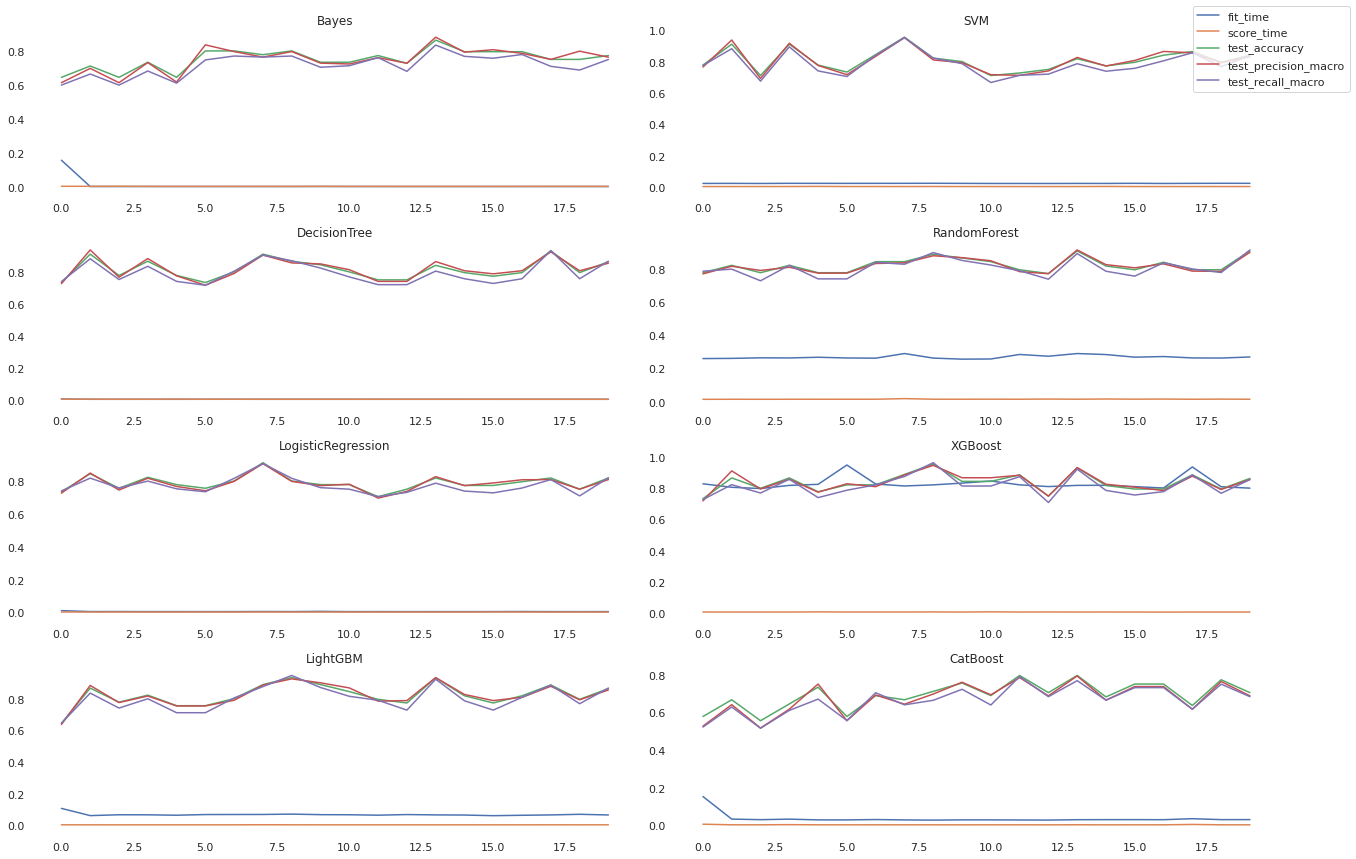

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,12))

for model in range(0, len(metrics_models)):
    name_model = list(metrics_models.keys())[model]
    plt.subplot(4, 2, model+1) # Uma figura com 3 linhas e 1 coluna
    plt.plot(pd.DataFrame(metrics_models[name_model]))
    plt.title(name_model)

fig.legend(list(metrics_models.values())[0].keys(), bbox_to_anchor=(1.05, 1), loc='upper right')

plt.tight_layout()  # Ajuste os espaços entre os subplots
plt.show()


In [34]:
metrics_df = pd.DataFrame(metrics_models).T.drop(columns={'fit_time', 'score_time'})
metrics_df.test_accuracy = metrics_df['test_accuracy'].apply(lambda x: np.mean(x))
metrics_df.test_precision_macro = metrics_df['test_precision_macro'].apply(lambda x: np.mean(x))
metrics_df.test_recall_macro = metrics_df['test_recall_macro'].apply(lambda x: np.mean(x))
metrics_df

,test_accuracy,test_precision_macro,test_recall_macro
Bayes,0.752247,0.748990,0.717242
SVM,0.808005,0.805657,0.786150
DecisionTree,0.815884,0.817804,0.794153
RandomForest,0.823813,0.820960,0.808014
LogisticRegression,0.787778,0.784345,0.771450
XGBoost,0.837247,0.839162,0.816960
LightGBM,0.821616,0.822086,0.801887
CatBoost,0.692879,0.677997,0.664387


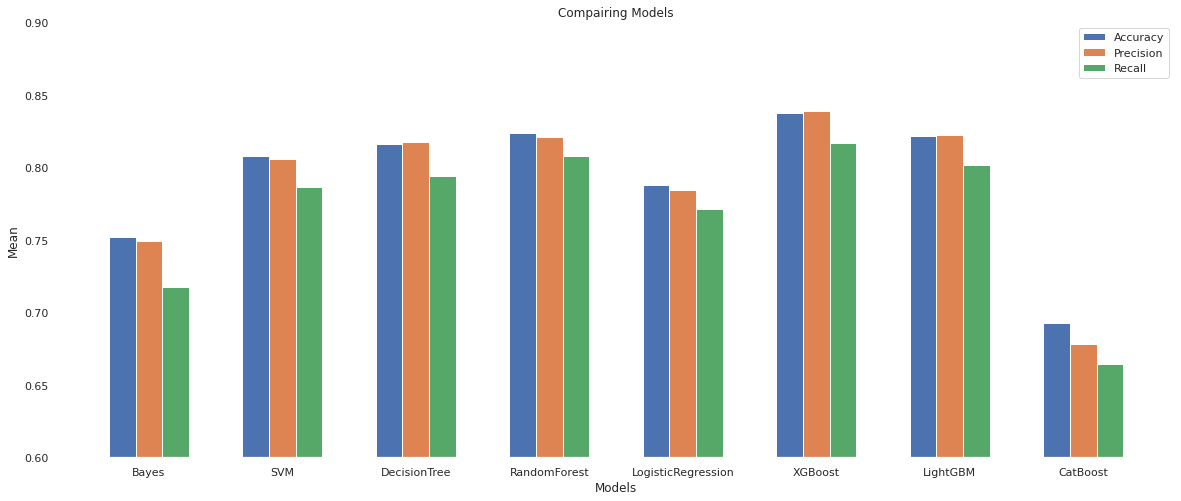

In [35]:
X = list(metrics_df.index)
fig, ax = plt.subplots(figsize=(20, 8))
X_axis = np.arange(len(X))

ax.bar(X_axis - 0.2, list(metrics_df.test_accuracy), 0.2, label='Accuracy')
ax.bar(X_axis, list(metrics_df.test_precision_macro), 0.2, label='Precision')
ax.bar(X_axis + 0.2, list(metrics_df.test_recall_macro), 0.2, label='Recall')

ax.set_xticks(X_axis)
ax.set_xticklabels(X)
ax.set_ylim(0.6, 0.9)

ax.set_xlabel("Models")
ax.set_ylabel("Mean")
ax.set_title("Compairing Models")
ax.legend()

plt.show()

## Choosing the Model

In [36]:
testX, _ = data_preparation(test.drop(columns={'SibSp', 'Parch'}))
predictions = modelXGB.predict(testX)

In [37]:
df_predicted = pd.DataFrame(predictions).set_index(test['PassengerId']).reset_index()
df_predicted.rename(columns={0: 'Survived'}, inplace=True)
df_predicted.to_csv('submission.csv', index=False)

In [38]:
df_predicted

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
